In [37]:
# =========================
# Machine Learning Pipeline
# =========================
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# General settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)



In [38]:
# =========================
# Step 1: Load & Prepare Data
# =========================

# Replace this with your actual CSV file
df = pd.read_csv("signal-data.csv")  # <-- Replace with your filename
target_column = "Pass/Fail"

# Explore the Data
print("Initial Data Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Drop columns with more than 90% missing values
df = df.loc[:, df.isnull().mean() < 0.9]

# Drop non-numeric (object) columns
dropped_obj_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(columns=dropped_obj_cols)

# Impute missing values in numeric columns
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

# Check that target exists
assert target_column in df.columns, f"'{target_column}' not found in dataset"

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column].map({-1: 0, 1: 1})  # map -1 to 0 if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data Shapes:")
print(f"  - Train (after SMOTE): {X_train_scaled.shape}")
print(f"  - Test: {X_test_scaled.shape}")


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None

Missing Values:
Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

✅ Data Shapes:
  - Train (after SMOTE): (2340, 586)
  - Test: (314, 586)


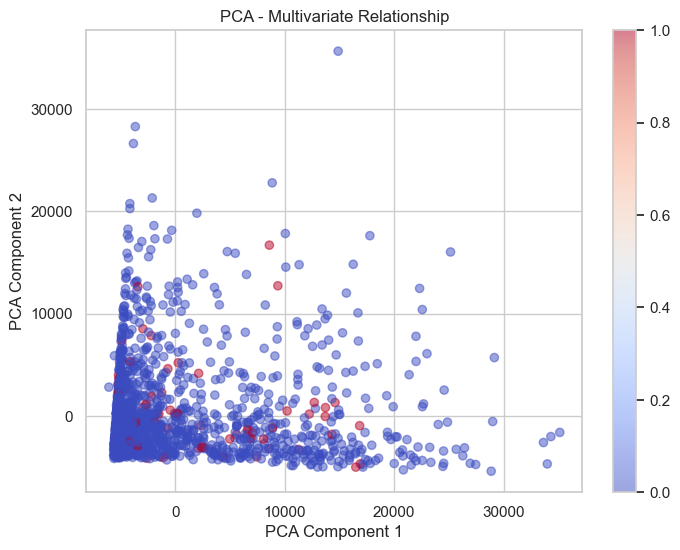

In [39]:
# ========================
# PCA: Principal Component Analysis (2D Projection)
# ========================
#Principal Component Analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - Multivariate Relationship")
plt.colorbar()
plt.show()

In [40]:
# =========================
# Step 2: Feature Selection
# =========================

# Select top 20 features
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train_bal)
X_test_sel = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"\n✅ Selected Features (Top 20):\n{selected_features.tolist()}")



✅ Selected Features (Top 20):
['7', '100', '104', '116', '121', '123', '124', '131', '143', '155', '166', '167', '219', '239', '278', '288', '366', '368', '376', '584']



🧠 Model: RandomForest
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       293
           1       0.18      0.14      0.16        21

    accuracy                           0.90       314
   macro avg       0.56      0.55      0.55       314
weighted avg       0.89      0.90      0.89       314

Confusion Matrix:
 [[279  14]
 [ 18   3]]

🧠 Model: XGBoost
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       293
           1       0.09      0.05      0.06        21

    accuracy                           0.90       314
   macro avg       0.51      0.51      0.51       314
weighted avg       0.88      0.90      0.89       314

Confusion Matrix:
 [[283  10]
 [ 20   1]]

🧠 Model: SVM
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       293
           1       0.12      0.33      0.17        21

    accuracy                           0.79

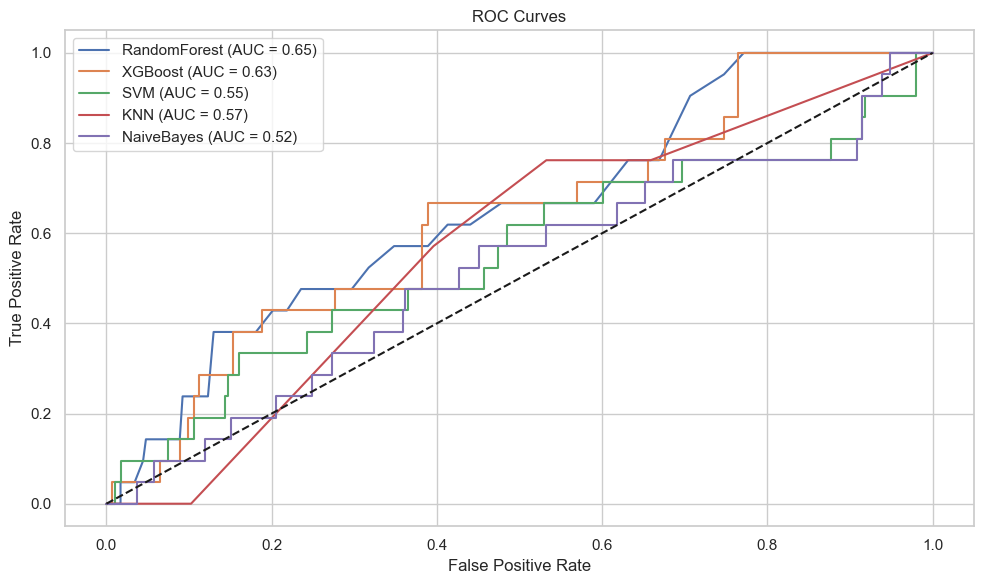

In [41]:
# =========================
# Step 3: Model Training & Evaluation
# =========================

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}

results = []

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC AUC": auc
    })

    print(f"\n Model: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.figure(figsize=(10, 6))
for name, model in models.items():
    evaluate_model(name, model, X_train_sel, y_train_bal, X_test_sel, y_test)

# ROC Curve plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# =========================
# Step 4: Results Summary
# =========================

results_df = pd.DataFrame(results)
print("\n📊 Model Comparison:")
print(results_df)


📊 Model Comparison:
          Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  RandomForest  0.898089   0.176471  0.142857  0.157895  0.649927
1       XGBoost  0.904459   0.090909  0.047619  0.062500  0.632049
2           SVM  0.786624   0.116667  0.333333  0.172840  0.549976
3           KNN  0.601911   0.093750  0.571429  0.161074  0.571754
4    NaiveBayes  0.315287   0.070796  0.761905  0.129555  0.517796


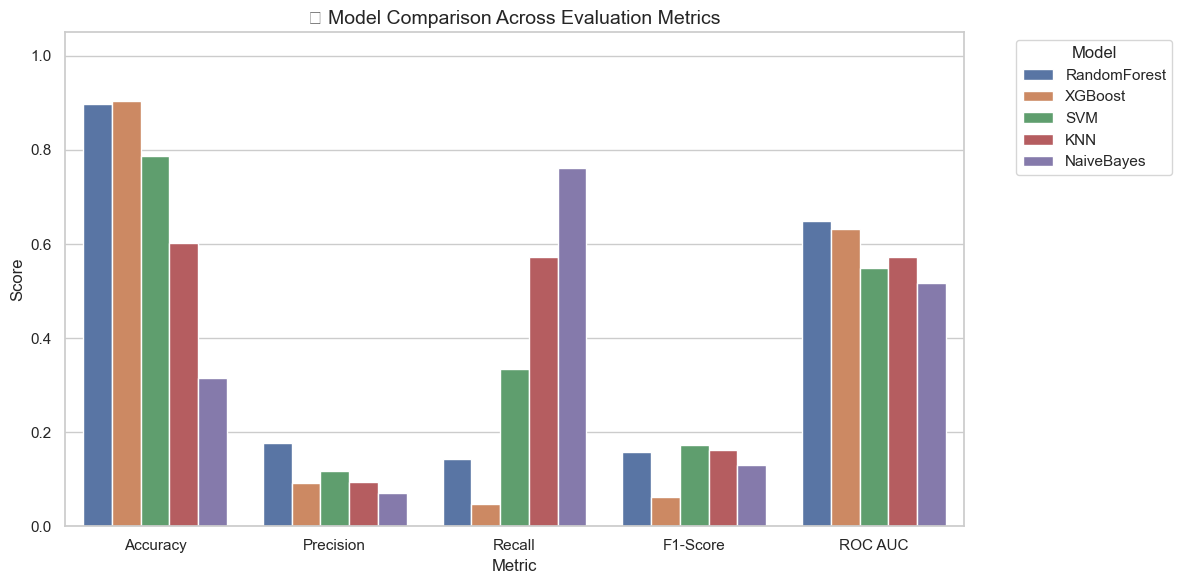

In [43]:
# Melt for plotting
metrics_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model')

plt.title("📊 Model Comparison Across Evaluation Metrics", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1.05)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()